In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,precision_score,recall_score,f1_score,roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,validation_curve,StratifiedKFold, learning_curve

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
train_df = pd.read_csv('train.csv')

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [5]:
test_df = pd.read_csv('test.csv')

In [6]:
df1 = train_df.copy()
df_val = test_df.copy()

In [7]:
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


### Dealing with Missing Values

In [10]:
print('Columns with null values:\n',df1.isna().sum())

Columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [11]:
df1['Age'].fillna(df1.groupby('Sex')['Age'].transform('mean'),inplace=True)
print('Columns with null values:\n',df1.isna().sum())

Columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [12]:
def fillna (data,col):
    data[col].fillna(data[col].mode()[0],inplace=True)
    print(data.isna().sum())
    
fillna(df1,'Embarked')

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [13]:
df1.drop(['PassengerId','Cabin','Ticket','Name'],axis=1,inplace=True)

In [14]:
df1.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [15]:
cat_col = [col for col in df1.columns if str(df1[col].dtype) in ['object']]
num_but_cat = [col for col in df1.columns if df1[col].nunique()<10 and df1[col].dtype in ['int64','float64']]
num_col = [col for col in df1.columns if df1[col].nunique()>10 and df1[col].dtype in ['int64','float64']]
num_w_cat = [col for col in df1.columns if str(df1[col].dtype) in ['int64','float64']]   

### Detect and Delete Outliers

In [16]:
for i in num_col:
  pltt=px.box(df1[i])
  pltt.show()

In [17]:
for i in num_col:
  q1 = df1[i].quantile(0.25)
  q3 = df1[i].quantile(0.75)
  iqr=q3-q1
  lower = q1-1.5*iqr
  upper = q3+1.5*iqr
  outlier_low = df1[df1[i]<lower][i]
  outlier_up = df1[df1[i]>upper][i]
  print('Lower fence:\n',outlier_low,'Upper fence:\n',outlier_up)
  outliers = pd.concat([outlier_low,outlier_up],axis=0).index
  indexes = []
  for o in outliers:
    indexes.append(o)
  print('Count of outliers:',len(indexes))
  #delete outliers
  clean_data = df1.drop(df1.index[indexes])
  print('Count of clean_data:',len(clean_data))

Lower fence:
 7      2.00
16     2.00
78     0.83
119    2.00
164    1.00
172    1.00
183    1.00
205    2.00
297    2.00
305    0.92
340    2.00
381    1.00
386    1.00
469    0.75
479    2.00
530    2.00
642    2.00
644    0.75
755    0.67
788    1.00
803    0.42
824    2.00
827    1.00
831    0.83
Name: Age, dtype: float64 Upper fence:
 11     58.0
15     55.0
33     66.0
54     65.0
94     59.0
96     71.0
116    70.5
152    55.5
170    61.0
174    56.0
195    58.0
232    59.0
252    62.0
268    58.0
275    63.0
280    65.0
326    61.0
366    60.0
438    64.0
456    65.0
467    56.0
483    63.0
487    58.0
492    55.0
493    71.0
545    64.0
555    62.0
570    62.0
587    60.0
625    61.0
626    57.0
630    80.0
647    56.0
659    58.0
672    70.0
684    60.0
694    60.0
745    70.0
772    57.0
829    62.0
851    74.0
879    56.0
Name: Age, dtype: float64
Count of outliers: 66
Count of clean_data: 825
Lower fence:
 Series([], Name: Fare, dtype: float64) Upper fence:
 1       71.283

In [18]:
for i in num_col:
  pltt=px.box(clean_data[i])
  pltt.show()

## Feature Analysis

### Numerical Values

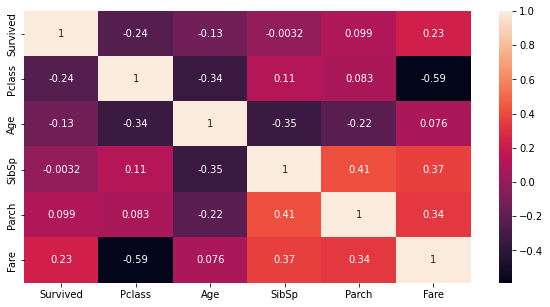

In [19]:
plt.figure(figsize=(10,5))
sns.heatmap(clean_data.corr(),annot=True)

#### Only Fare have a significant correlation with Survived column

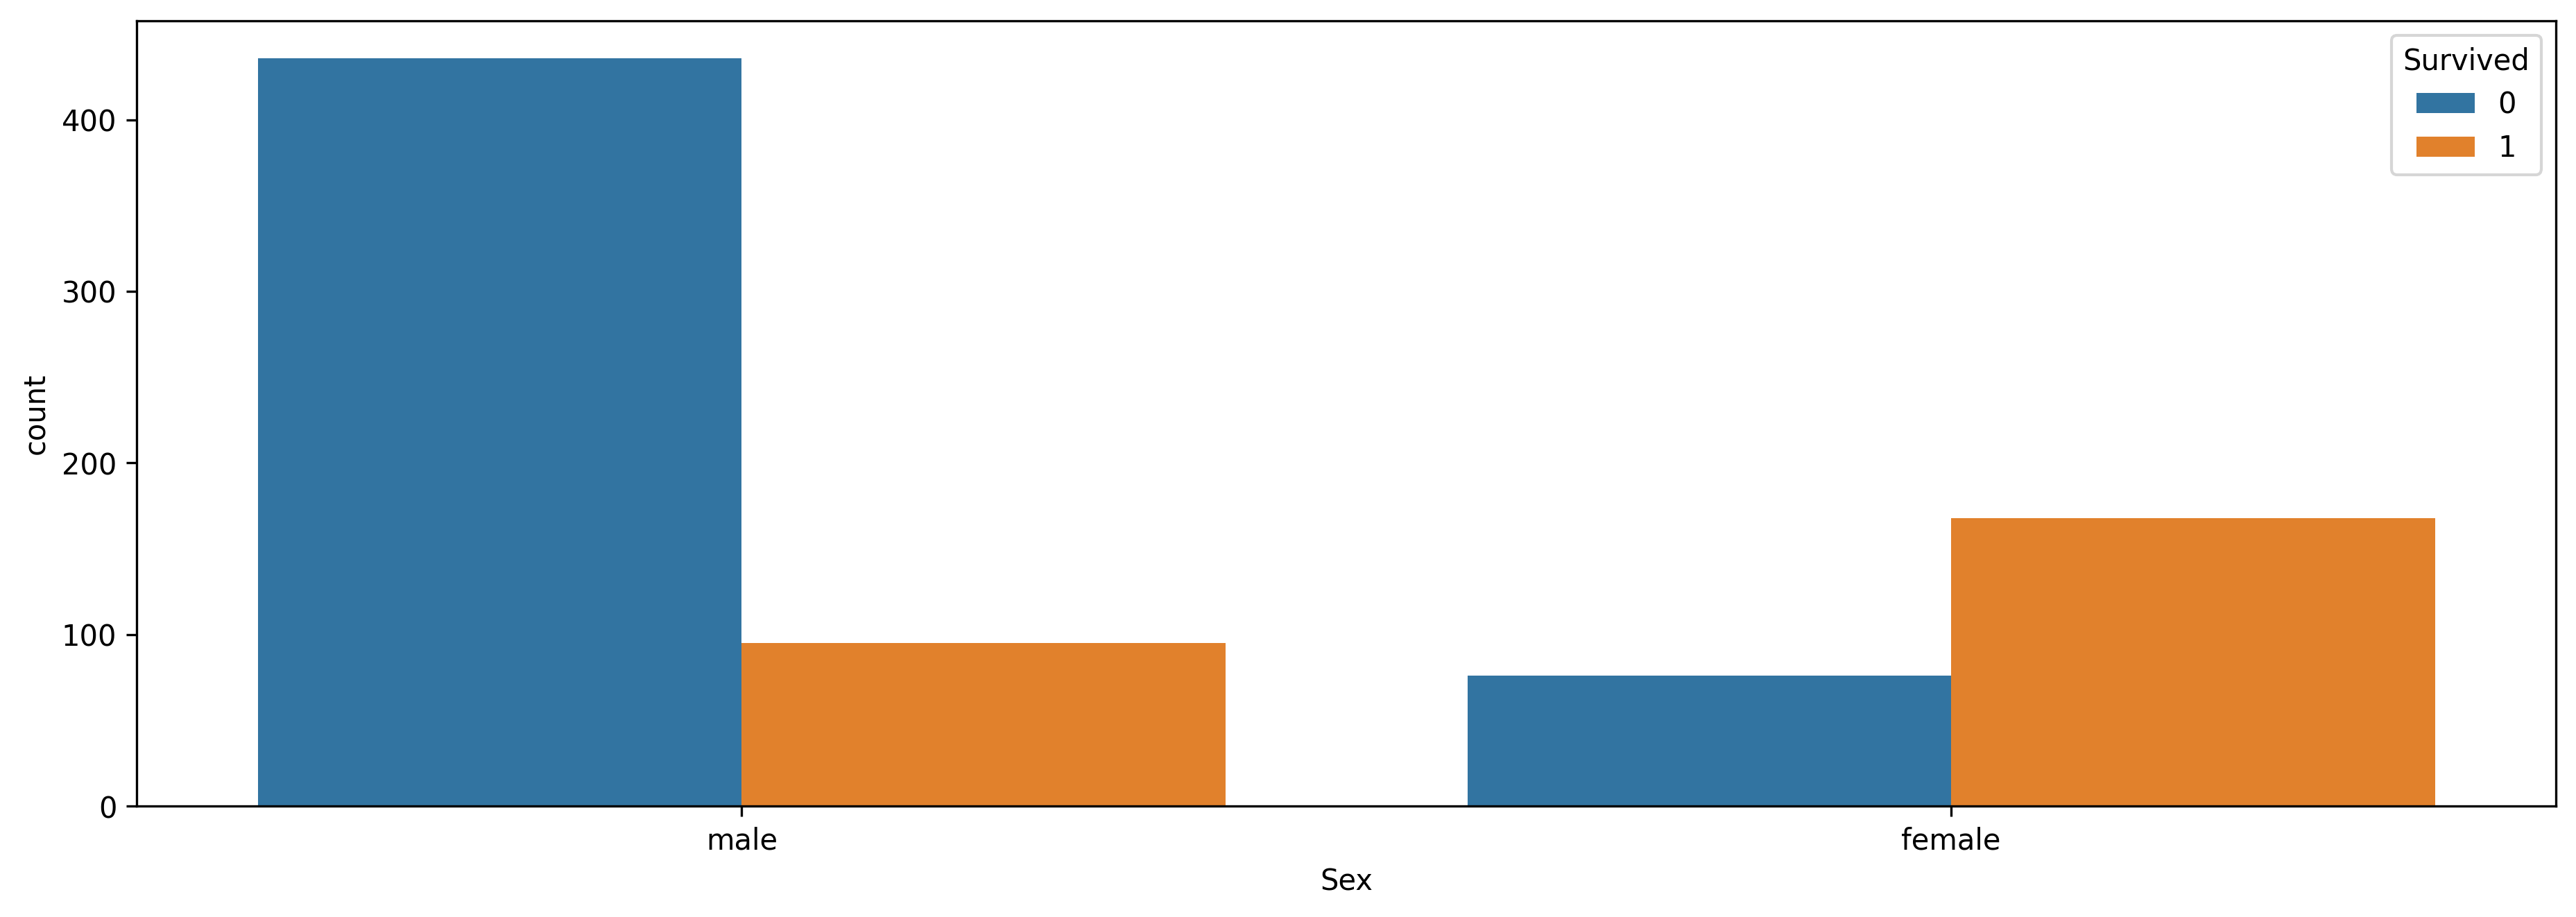

In [20]:
plt.figure(figsize=(15,5),dpi=300)
sns.countplot(data=clean_data,x = 'Sex',hue='Survived')

In [21]:
cols = ['Pclass','Age','SibSp','Parch','Embarked']

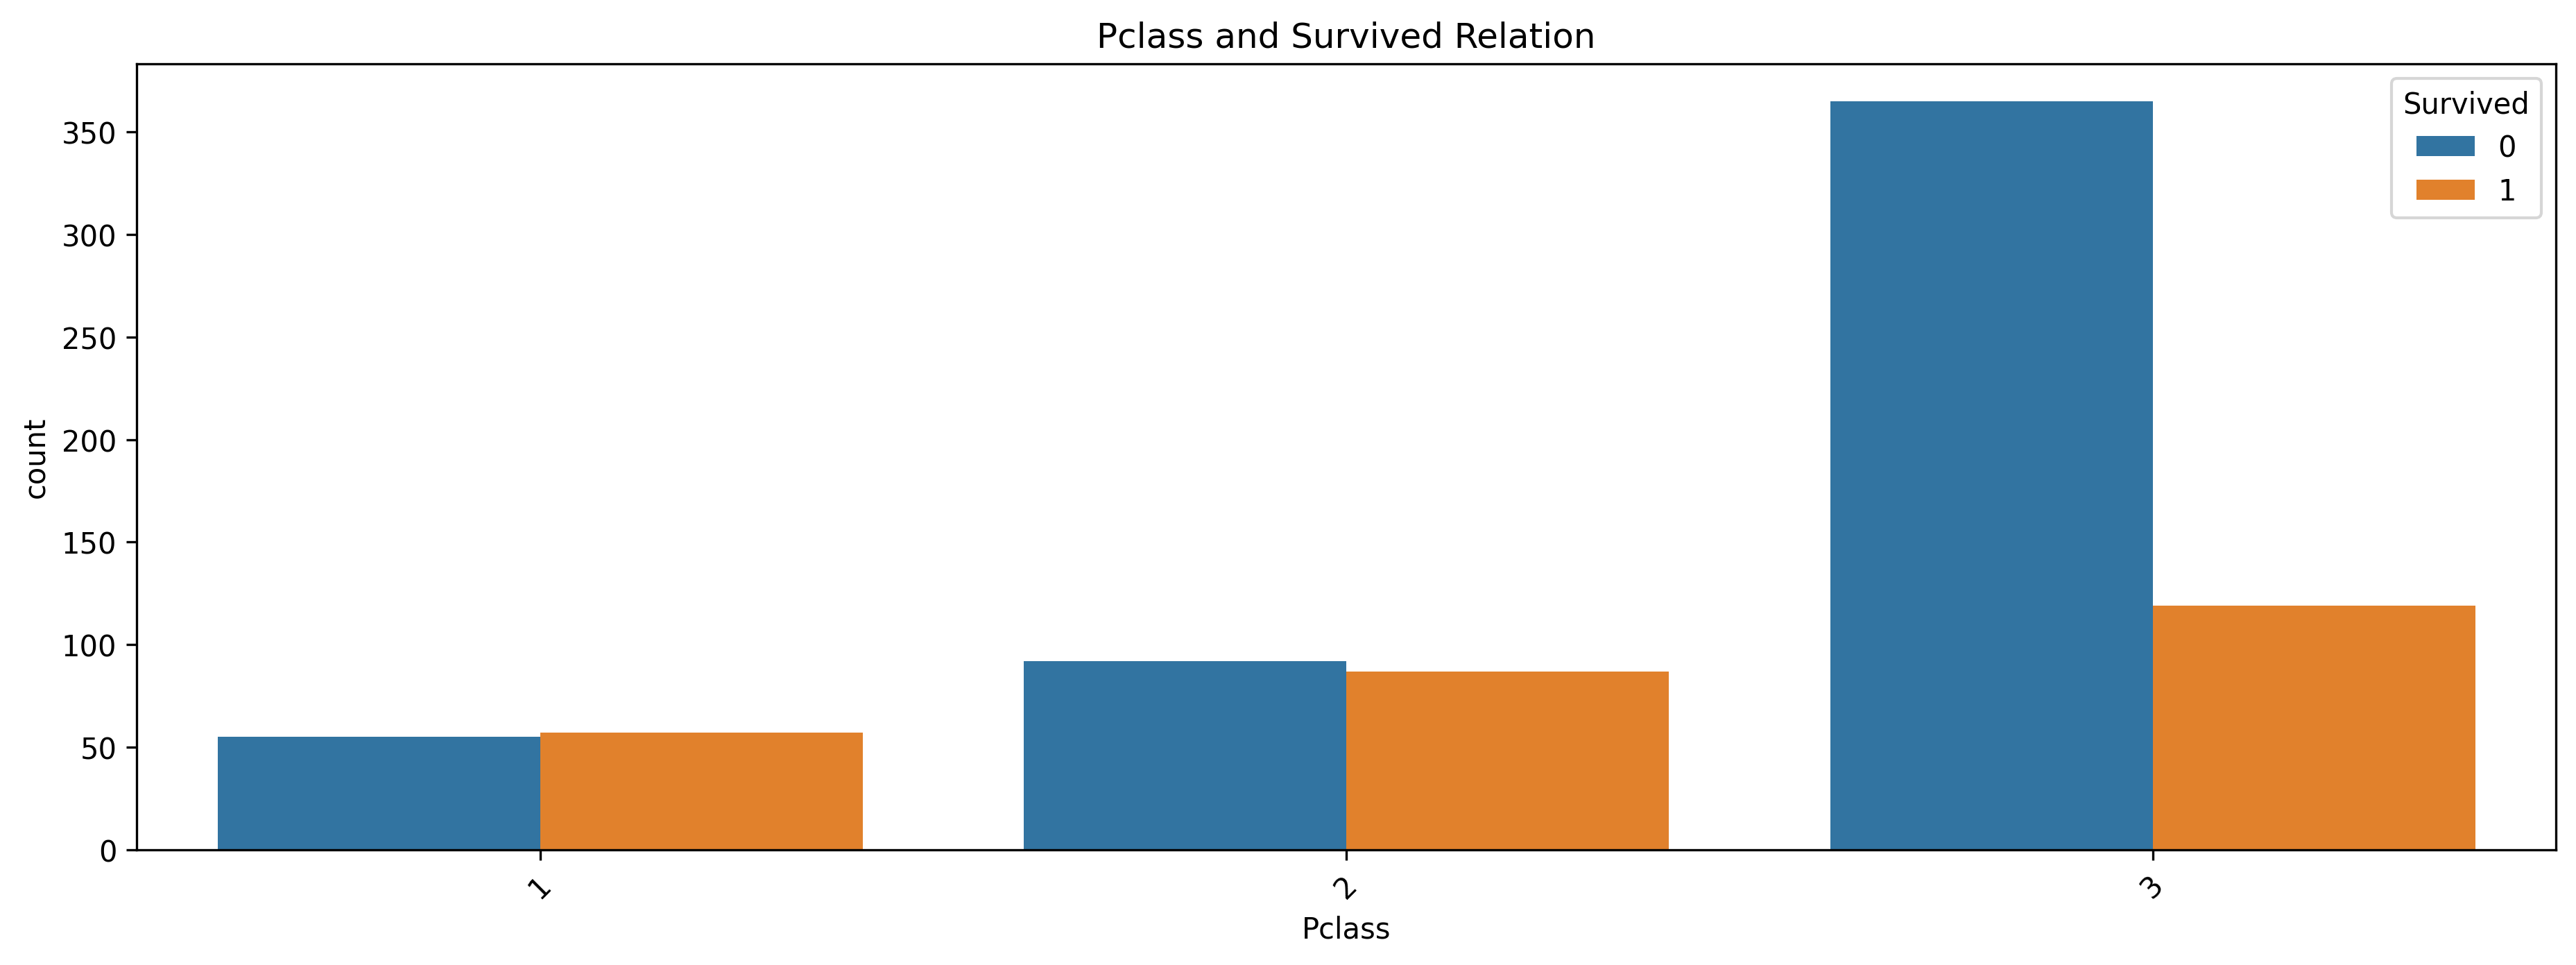

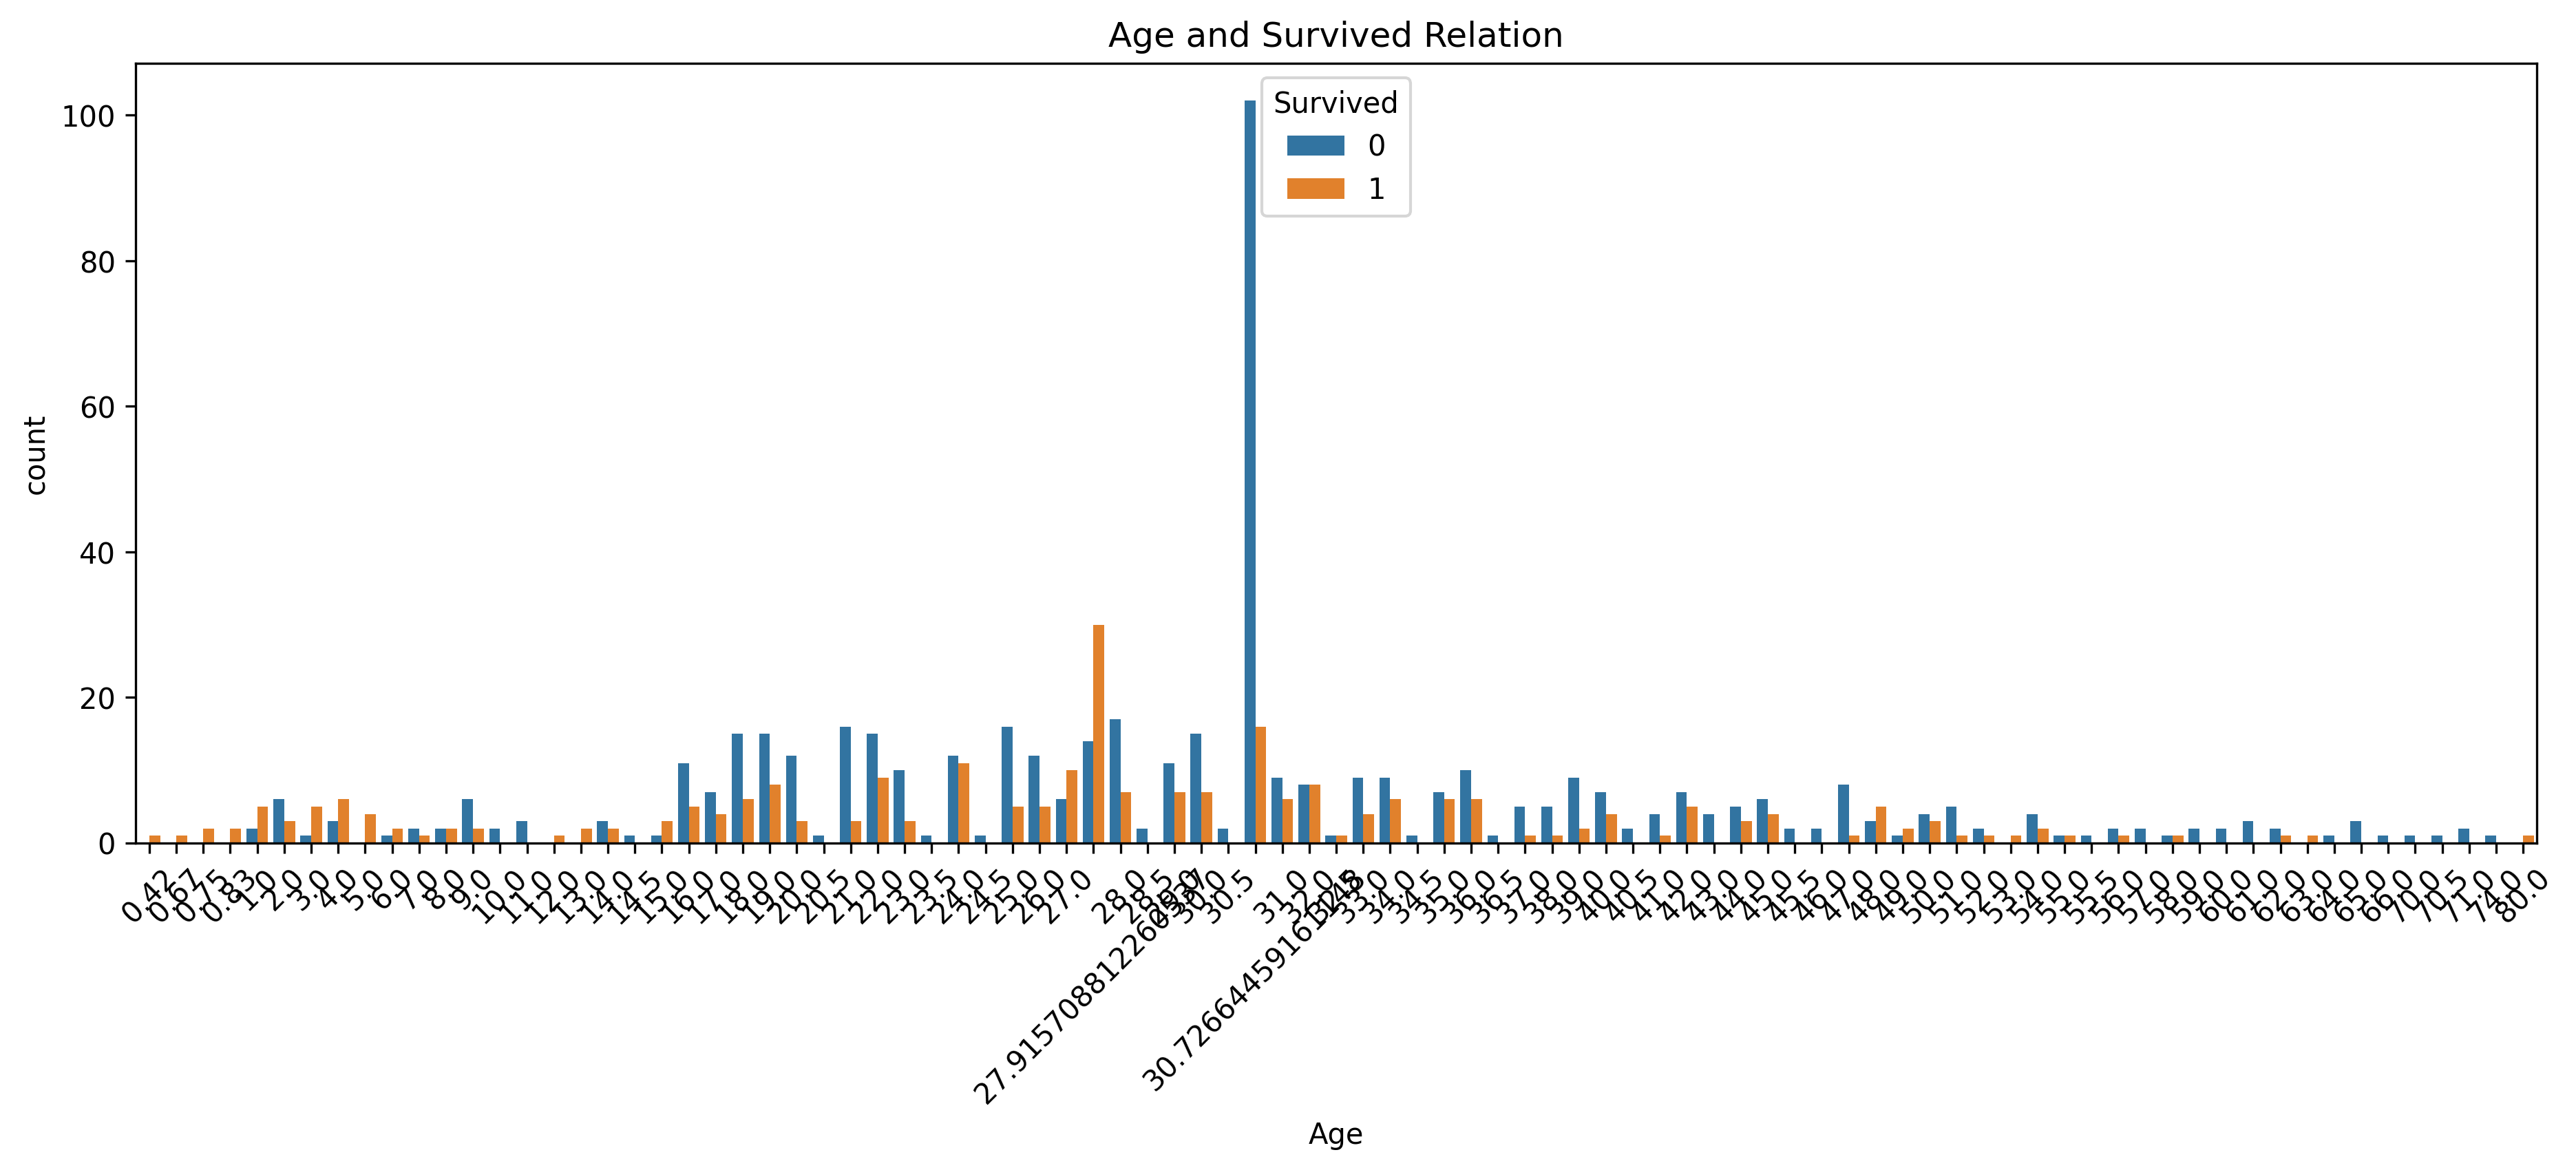

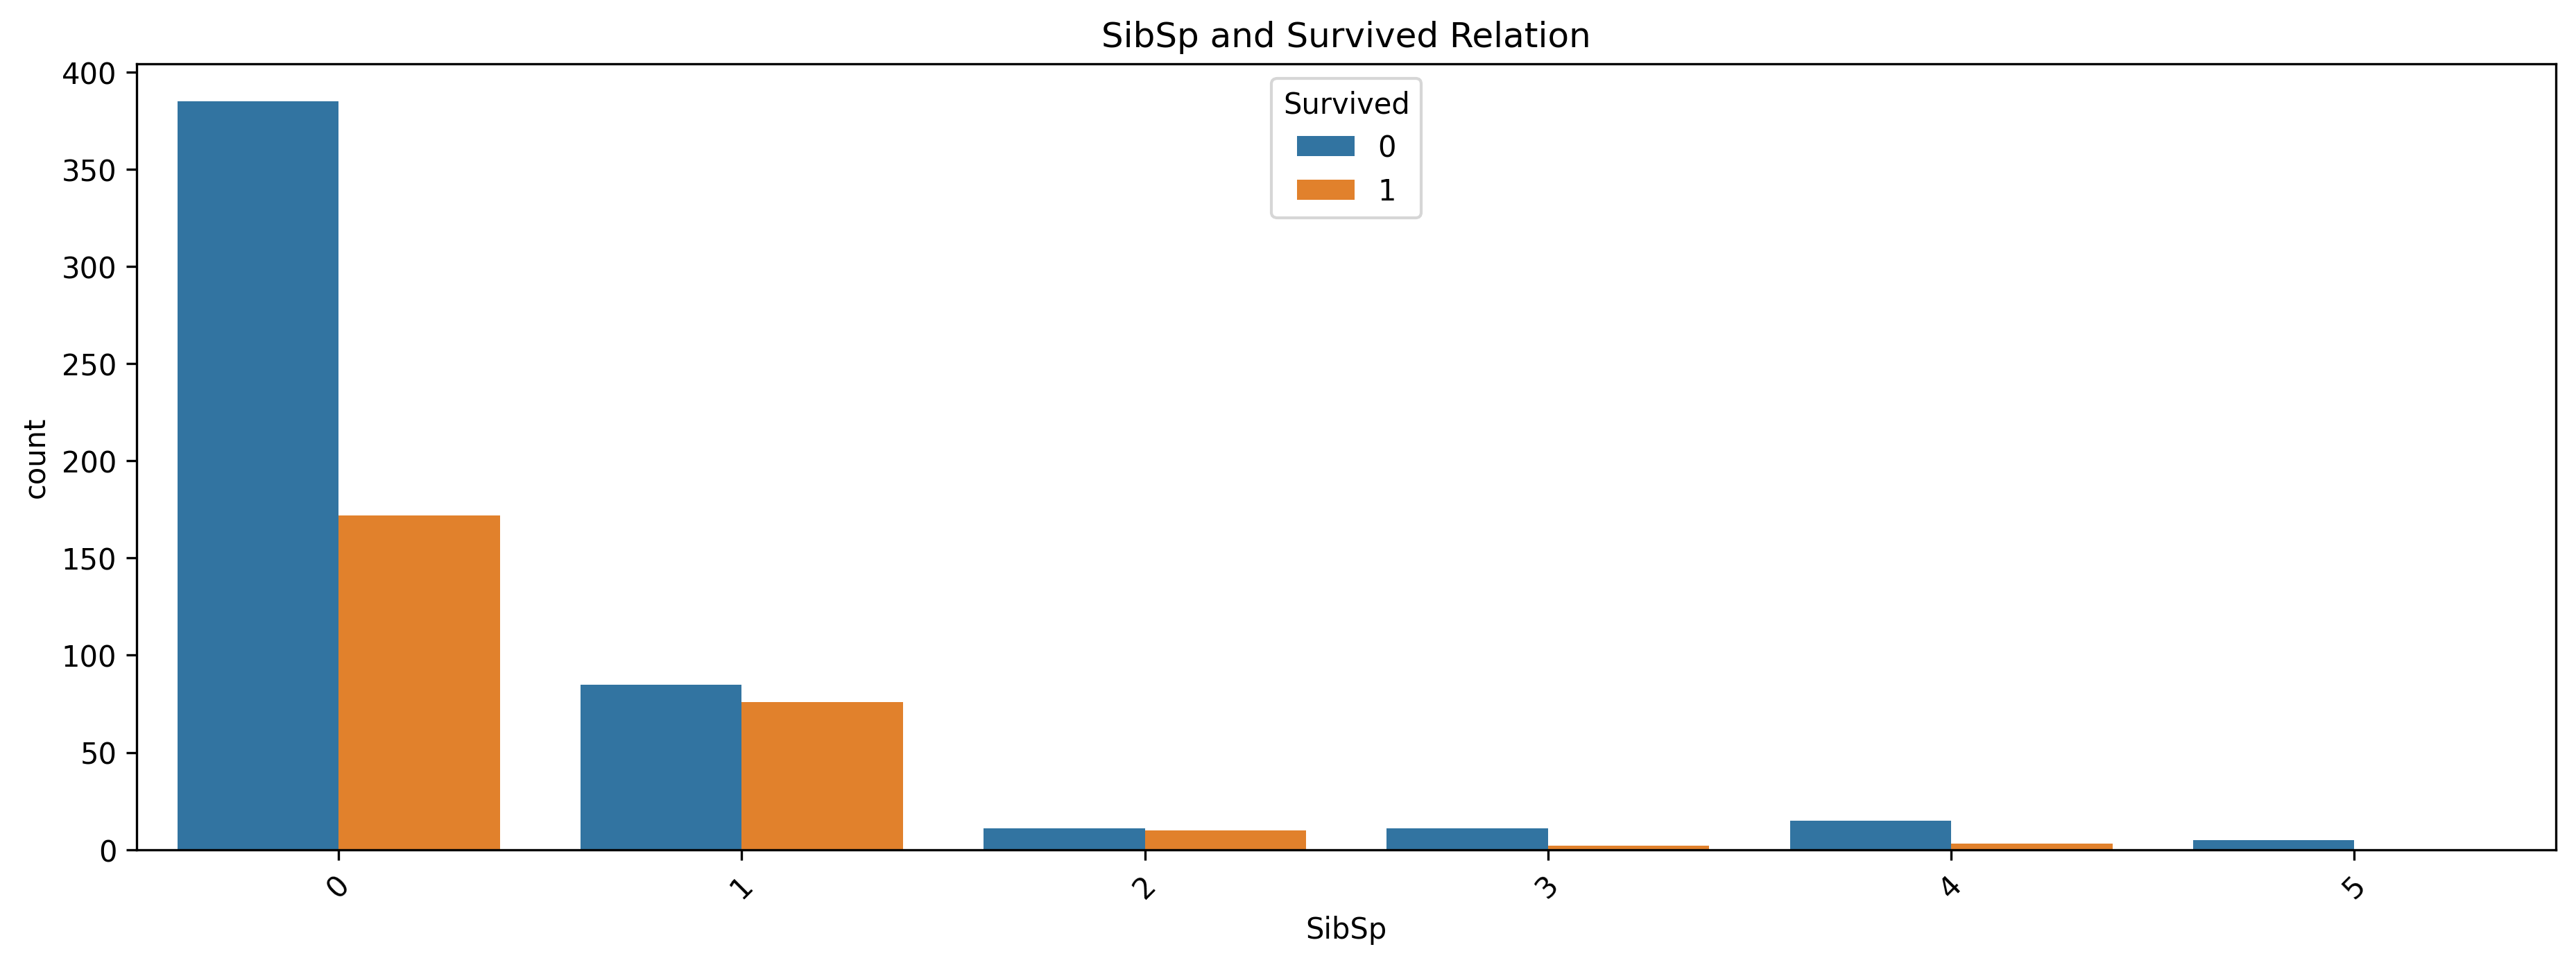

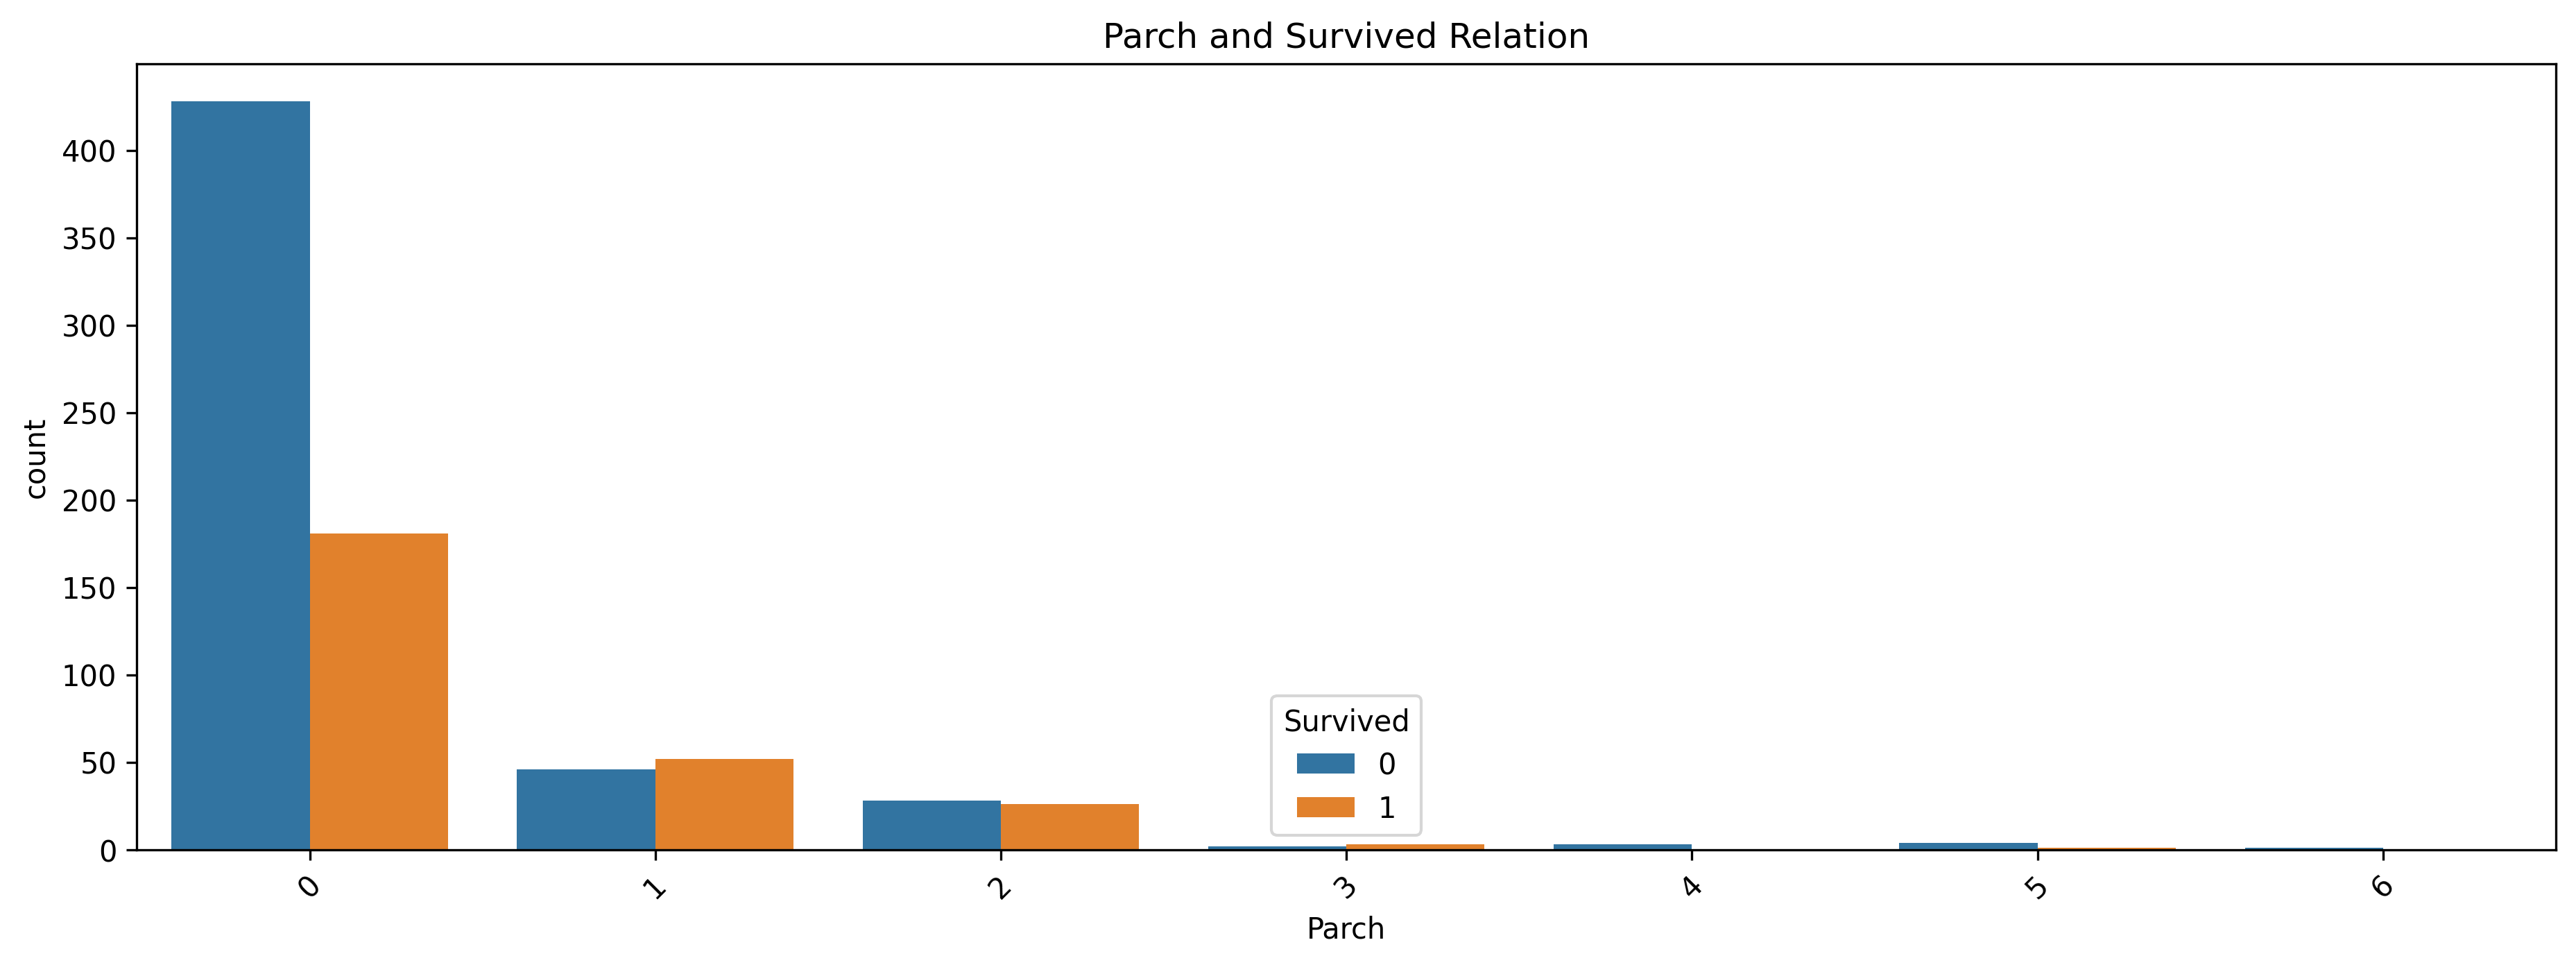

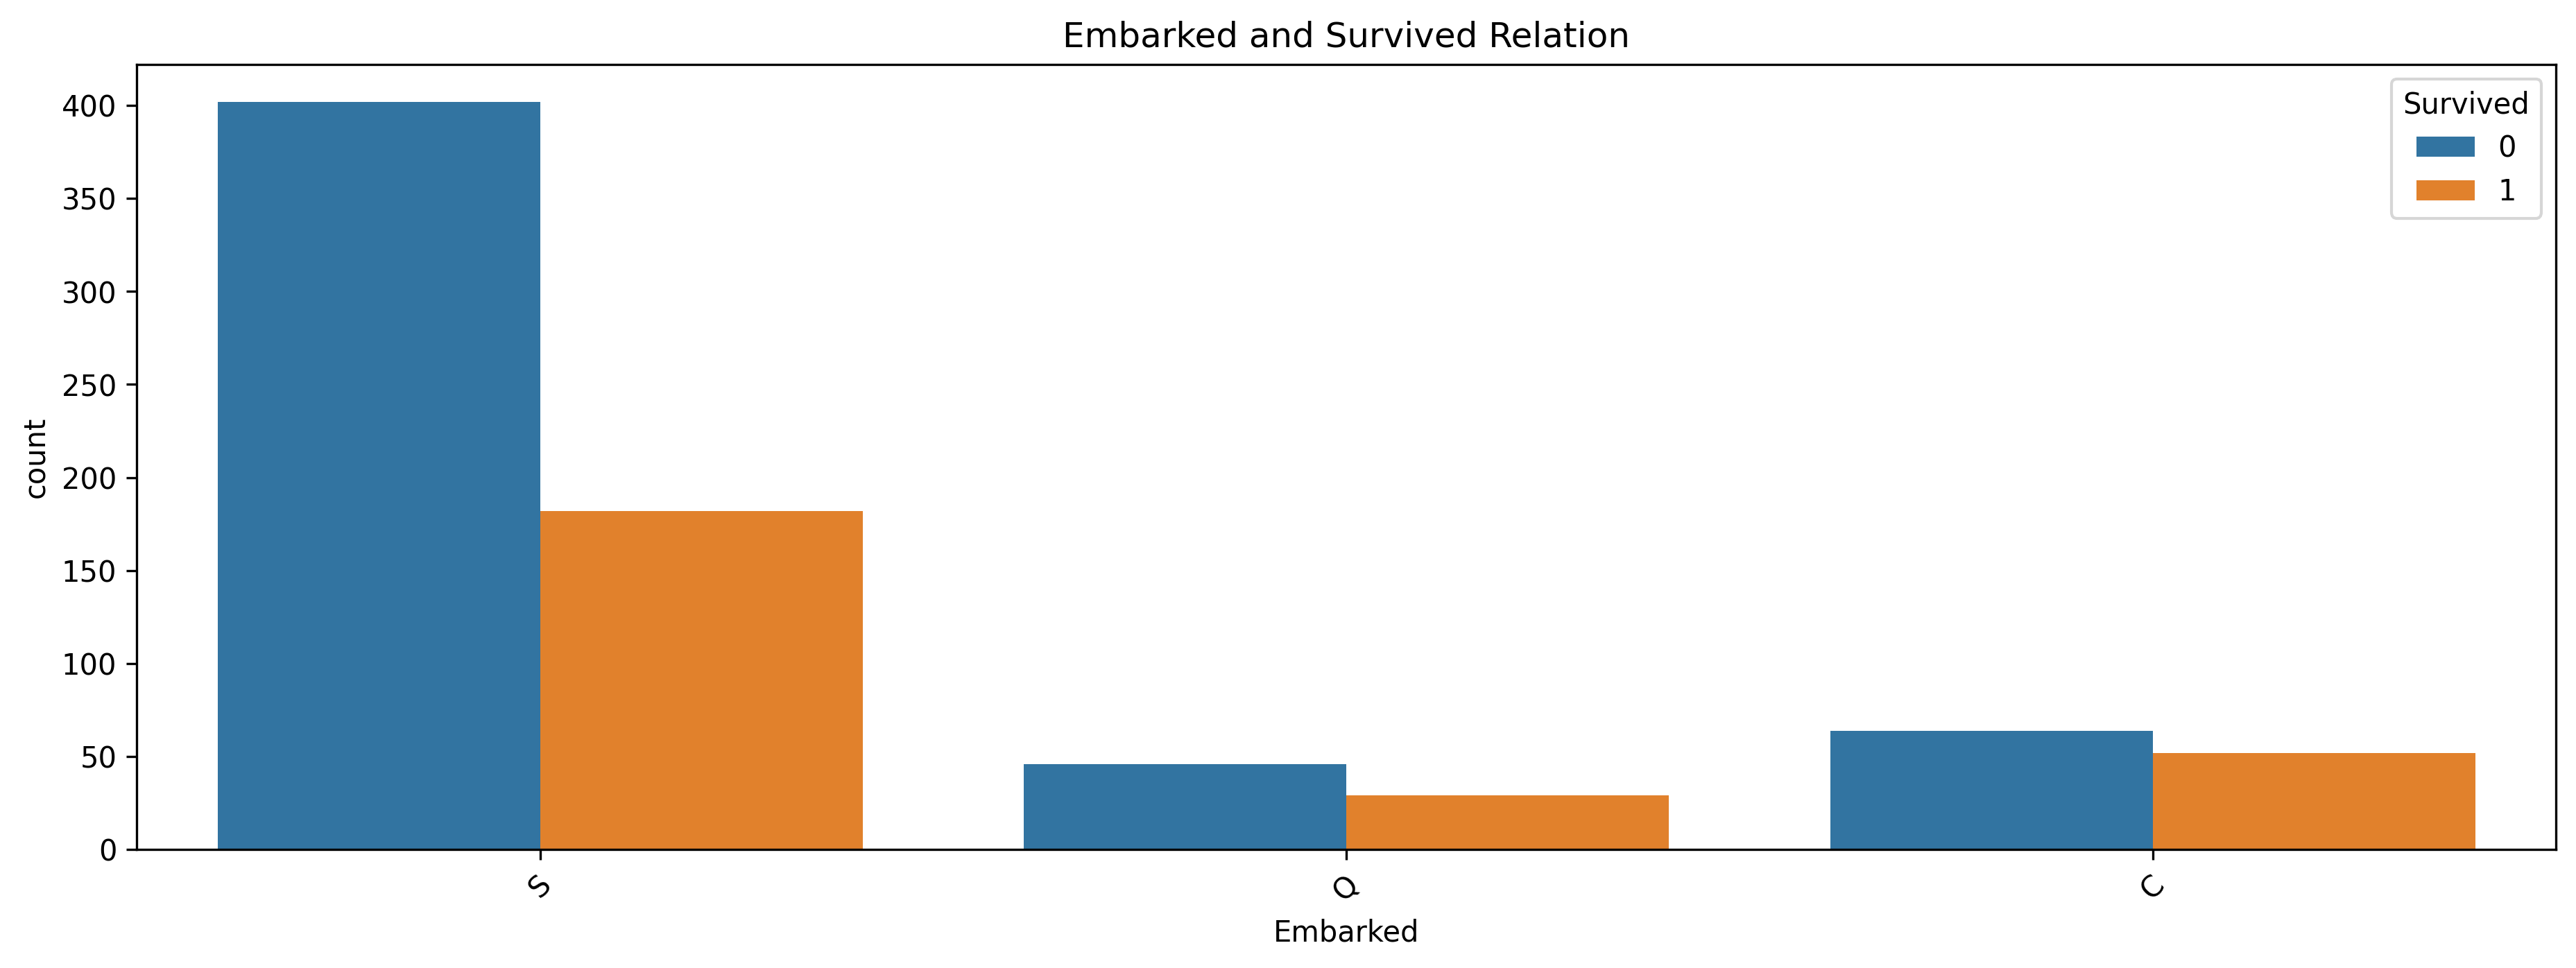

In [22]:
for i,col  in enumerate(cols):
    plt.figure(i,figsize=(15,5),dpi=300)
    sns.countplot(data=clean_data,x = col,hue='Survived')
    plt.xticks(rotation=45)
    plt.title(f'{col} and Survived Relation')
    

In [23]:
px.histogram(clean_data,'Fare',color='Survived')

In [24]:
px.box(clean_data,x='Sex',y='Age',color='Survived')

In [25]:
clean_data['Sex'].replace({'male':1,'female':0},inplace=True)

In [26]:
clean_data1=pd.get_dummies(clean_data,columns=['Embarked'],prefix='Em')

In [27]:
X = clean_data1.drop('Survived',axis=1)
y = clean_data1['Survived']

In [28]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,train_size=0.75,shuffle=True)

In [29]:
sc = StandardScaler()
xtrain = sc.fit_transform(xtrain)
xtest = sc.transform(xtest)

In [30]:
def modelpredict(model):
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    ytrainpred = model.predict(xtrain)
    acc = accuracy_score(ytest,ypred)
    trainacc = accuracy_score(ytrain,ytrainpred)
    pre = precision_score(ytest,ypred)
    re = recall_score(ytest,ypred)
    f1 = f1_score(ytest,ypred)
    return [acc,pre,re,f1,trainacc]

In [31]:
random_state=2
models = [SVC(random_state=random_state),DecisionTreeClassifier(random_state=random_state),
         KNeighborsClassifier(),LogisticRegression(random_state = random_state,max_iter=1000),
         LinearDiscriminantAnalysis(),RandomForestClassifier(random_state=random_state),
         GradientBoostingClassifier(random_state=random_state),
         MLPClassifier(random_state=random_state),AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)]

In [32]:
modelnames = ['SVC','Decision Tree','KNN','LogisticReg','LDA','RFC','GradientBoost','ADABoost','MLP']

In [33]:
result = []
for model in models:
    result.append(modelpredict(model))

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [34]:
df1 = pd.DataFrame(modelnames,columns=['Model name'])

df2 = pd.DataFrame(result,columns=['Validation Accuracy','Train Accuracy','Precision','Recall','F1'])

In [35]:
df3=df1.join(df2)

In [36]:
df3

,Model name,Validation Accuracy,Train Accuracy,Precision,Recall,F1
0,SVC,0.850515,0.875000,0.646154,0.743363,0.829604
1,Decision Tree,0.814433,0.737705,0.692308,0.714286,0.979346
2,KNN,0.798969,0.732143,0.630769,0.677686,0.858864
3,LogisticReg,0.824742,0.771930,0.676923,0.721311,0.779690
4,LDA,0.819588,0.767857,0.661538,0.710744,0.776248
5,RFC,0.835052,0.761905,0.738462,0.750000,0.979346
6,GradientBoost,0.855670,0.836364,0.707692,0.766667,0.893287
7,ADABoost,0.850515,0.846154,0.676923,0.752137,0.831325
8,MLP,0.804124,0.728814,0.661538,0.693548,0.979346


### I choose SVC, KNN,RandomForest and GradientBoosting,AdaBoosting classifiers for the modelling

#### Finding best parameters

In [37]:
def find_best_params(X, y):
    # Define the models and the parameter grids to search
    models = [{
            'name': 'SVC',
            'model': SVC(),
            'params': {
                'C': [0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'gamma': ['scale', 'auto']}},
        
            {'name': 'KNN',
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]}},
        
            {'name': 'RandomForest',
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'max_features': ['sqrt', 'log2']}},
        
            {'name': 'GradientBoosting',
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.1, 0.01, 0.001]}},
              {'name':'AdaBoosting',
               'model':AdaBoostClassifier(),
               'params':{
                   'n_estimators': [50, 100, 200],
                  'learning_rate': [0.01, 0.1, 1.0]
               }}]

    best_params = {}

    # Loop over models and find the best hyperparameters for each
    for model in models:
        print(f"Finding best hyperparameters for {model['name']}...")

        # Perform a grid search with cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
        grid = GridSearchCV(model['model'], model['params'], cv=cv, n_jobs=-1,scoring='accuracy')
        grid.fit(X, y)

        # Print the best hyperparameters and the accuracy on the validation set
        print(f"Best hyperparameters: {grid.best_params_}")
        print(f"Validation accuracy: {grid.best_score_}")

        # Store the best hyperparameters for each model in a dictionary
        best_params[model['name']] = grid.best_params_

    return best_params

In [38]:
find_best_params(xtrain,ytrain)

Finding best hyperparameters for SVC...
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Validation accuracy: 0.802077807250221
Finding best hyperparameters for KNN...
Best hyperparameters: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
Validation accuracy: 0.7882699675803124
Finding best hyperparameters for RandomForest...
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Validation accuracy: 0.8037577365163571
Finding best hyperparameters for GradientBoosting...
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Validation accuracy: 0.8106690244621279
Finding best hyperparameters for AdaBoosting...
Best hyperparameters: {'learning_rate': 1.0, 'n_estimators': 50}
Validation accuracy: 0.7882847038019452


{'SVC': {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'},
 'KNN': {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'},
 'RandomForest': {'max_depth': 10,
  'max_features': 'sqrt',
  'n_estimators': 300},
 'GradientBoosting': {'learning_rate': 0.01,
  'max_depth': 3,
  'n_estimators': 300},
 'AdaBoosting': {'learning_rate': 1.0, 'n_estimators': 50}}

In [39]:
svcbest = SVC(C=1,gamma='scale',kernel='rbf',probability=True).fit(xtrain,ytrain)
ypredsvc = svcbest.predict(xtest)
ypredsvc_train = svcbest.predict(xtrain)
svc_acc_train = accuracy_score(ytrain,ypredsvc_train)
accsvc = accuracy_score(ytest,ypredsvc)
presvc = precision_score(ytest,ypredsvc)
resvc = recall_score(ytest,ypredsvc)
f1svc = f1_score(ytest,ypredsvc)

In [40]:
knnbest = KNeighborsClassifier(n_neighbors=9,p=2,weights='uniform').fit(xtrain,ytrain)
ypredknn = knnbest.predict(xtest)
ypredknn_train = knnbest.predict(xtrain)
knn_acc_train = accuracy_score(ytrain,ypredknn_train)
accknn = accuracy_score(ytest,ypredknn)
preknn = precision_score(ytest,ypredknn)
reknn = recall_score(ytest,ypredknn)
f1knn = f1_score(ytest,ypredknn)

In [41]:
rfbest = RandomForestClassifier(max_depth=10,max_features='sqrt',n_estimators=300).fit(xtrain,ytrain)
ypredrf = rfbest.predict(xtest)
ypredrf_train = rfbest.predict(xtrain)
rf_acc_train = accuracy_score(ytrain,ypredrf_train)
accrf = accuracy_score(ytest,ypredrf)
prerf = precision_score(ytest,ypredrf)
rerf = recall_score(ytest,ypredrf)
f1rf = f1_score(ytest,ypredrf)

In [42]:
gbbest = GradientBoostingClassifier(learning_rate=0.01,max_depth=3,n_estimators=300).fit(xtrain,ytrain)
ypredgb = gbbest.predict(xtest)
ypredgb_train = gbbest.predict(xtrain)
gb_acc_train = accuracy_score(ytrain,ypredgb_train)
accgb = accuracy_score(ytest,ypredgb)
pregb = precision_score(ytest,ypredgb)
regb = recall_score(ytest,ypredgb)
f1gb = f1_score(ytest,ypredgb)

In [43]:
abbest = AdaBoostClassifier(learning_rate=1,n_estimators=50).fit(xtrain,ytrain)
ypredab = abbest.predict(xtest)
ypredab_train = abbest.predict(xtrain)
ab_acc_train = accuracy_score(ytrain,ypredab_train)
accab = accuracy_score(ytest,ypredab)
preab = precision_score(ytest,ypredab)
reab = recall_score(ytest,ypredab)
f1ab = f1_score(ytest,ypredab)

### Final Results

In [44]:
models = ['SVC','KNN','RandomForest','GradientBoosting','AdaBoost']
accuracy_scores = [accsvc,accknn,accrf,accgb,accab]
train_acc_scores = [svc_acc_train,knn_acc_train,rf_acc_train,gb_acc_train,ab_acc_train]
pre_scores = [presvc,preknn,prerf,pregb,preab]
re_scores = [resvc,reknn,rerf,regb,reab]
f1_scores = [f1svc,f1knn,f1rf,f1gb,f1ab]

In [45]:
def result_df(models, accuracy_scores):
    df = pd.DataFrame({'Model': models, 'Accuracy': accuracy_scores,'Precision':pre_scores,'Recall':re_scores,'F1':f1_scores})
    return df

In [46]:
result_df(models,accuracy_scores)

,Model,Accuracy,Precision,Recall,F1
0,SVC,0.850515,0.875000,0.646154,0.743363
1,KNN,0.850515,0.860000,0.661538,0.747826
2,RandomForest,0.860825,0.827586,0.738462,0.780488
3,GradientBoosting,0.845361,0.888889,0.615385,0.727273
4,AdaBoost,0.819588,0.812500,0.600000,0.690265


In [47]:
def train_acc(models,train_acc_scores,accuracy_scores):
    df2 = pd.DataFrame({'Model':models,'Train accuracy': train_acc_scores,'Validation accuracy':accuracy_scores})
    return df2

In [48]:
train_acc(models,train_acc_scores,accuracy_scores)

,Model,Train accuracy,Validation accuracy
0,SVC,0.829604,0.850515
1,KNN,0.836489,0.850515
2,RandomForest,0.946644,0.860825
3,GradientBoosting,0.841652,0.845361
4,AdaBoost,0.831325,0.819588


### Learning curve

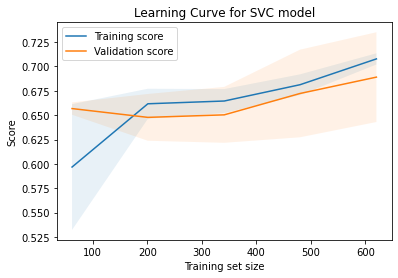

In [49]:
#[svcbest,knnbest,rfbest,gbbest]

train_sizes, train_scores, test_scores = learning_curve(svcbest, X, y, cv=5,scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve for SVC model')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

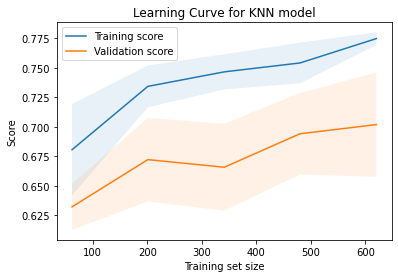

In [50]:
train_sizes, train_scores, test_scores = learning_curve(knnbest, X, y, cv=5,scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve for KNN model')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

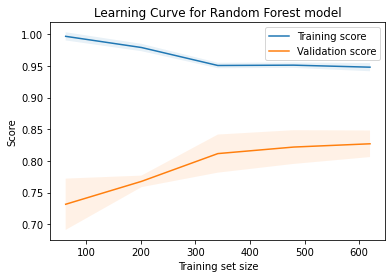

In [51]:
train_sizes, train_scores, test_scores = learning_curve(rfbest, X, y, cv=5,scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve for Random Forest model')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

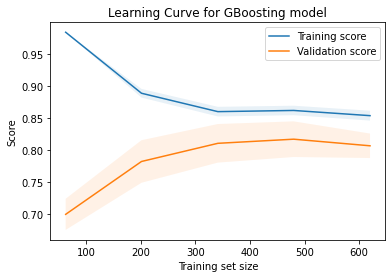

In [52]:
train_sizes, train_scores, test_scores = learning_curve(gbbest, X, y, cv=5,scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve for GBoosting model')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

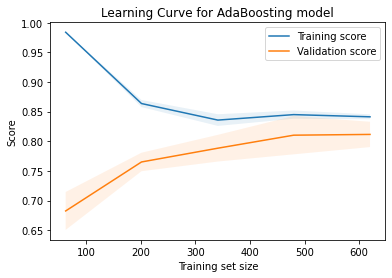

In [53]:

train_sizes, train_scores, test_scores = learning_curve(abbest, X, y, cv=5,scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve for AdaBoosting model')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

## ROC-AUC Score and Curves

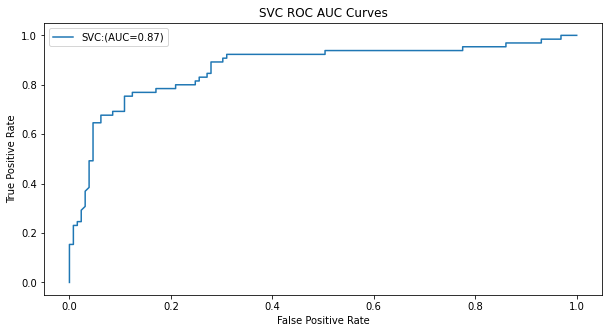

In [54]:
y_pred_proba = svcbest.predict_proba(xtest)[:, 1]
auc_score = roc_auc_score(ytest, y_pred_proba)

fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label=f'SVC:(AUC={auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC AUC Curves')
plt.legend()
plt.show()

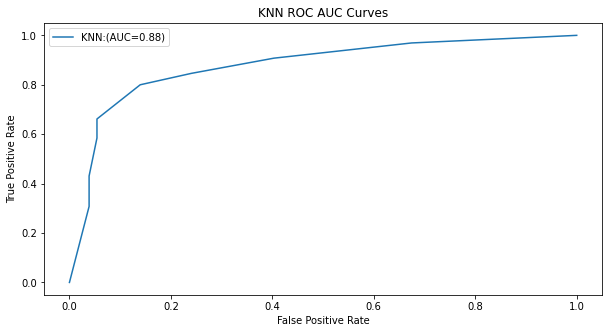

In [55]:
y_pred_proba = knnbest.predict_proba(xtest)[:, 1]
auc_score = roc_auc_score(ytest, y_pred_proba)

fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label=f'KNN:(AUC={auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC AUC Curves')
plt.legend()
plt.show()

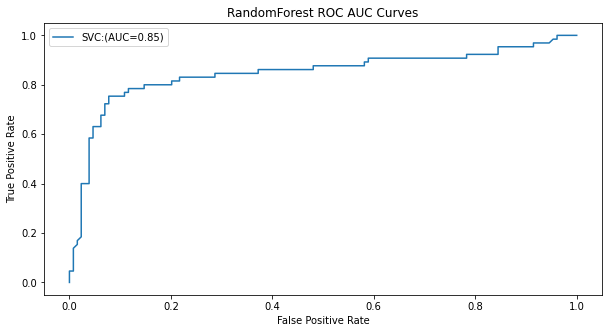

In [56]:
y_pred_proba = rfbest.predict_proba(xtest)[:, 1]
auc_score = roc_auc_score(ytest, y_pred_proba)

fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label=f'SVC:(AUC={auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest ROC AUC Curves')
plt.legend()
plt.show()

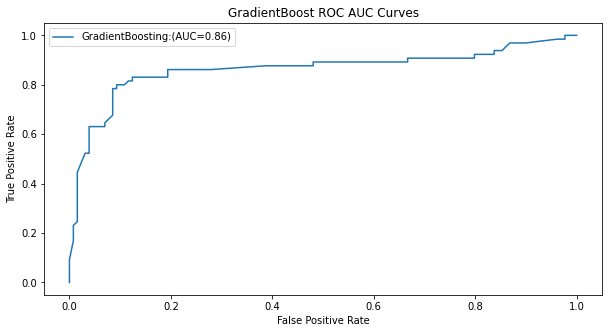

In [57]:
y_pred_proba = gbbest.predict_proba(xtest)[:, 1]
auc_score = roc_auc_score(ytest, y_pred_proba)

fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label=f'GradientBoosting:(AUC={auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GradientBoost ROC AUC Curves')
plt.legend()
plt.show()

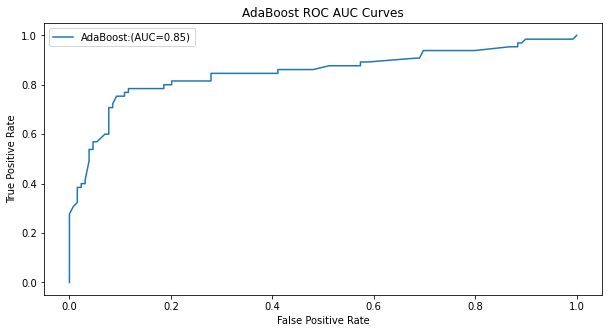

In [58]:
y_pred_proba = abbest.predict_proba(xtest)[:, 1]
auc_score = roc_auc_score(ytest, y_pred_proba)

fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label=f'AdaBoost:(AUC={auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC AUC Curves')
plt.legend()
plt.show()

In [59]:
def aucscore(model):
  y_pred_proba = model.predict_proba(xtest)[:, 1]
  auc_score = roc_auc_score(ytest, y_pred_proba)
  return auc_score

classifiers = {'SVC':svcbest,'KNN':knnbest,'RandomForest':rfbest,'GradientBoost':gbbest,'AdaBoost':abbest}
for name,score in classifiers.items():
  print('AUC Score:',name,aucscore(score))

AUC Score: SVC 0.8698867024448421
AUC Score: KNN 0.8770423375074539
AUC Score: RandomForest 0.8465712581991652
AUC Score: GradientBoost 0.862552176505665
AUC Score: AdaBoost 0.850268336314848
